# Import Library

In [67]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the Data


In [68]:
df_train = pd.read_csv('store.csv')
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [69]:
# Check  value
df_train['family'].value_counts()

AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY        

Semua data memiliki jumlah yang sama

In [70]:
# Menghapus selain kolom family dan sales

# hapus kolom id dan store_nbr
df_train.drop(['id', 'store_nbr','onpromotion','dcoilwtico'], axis=1, inplace=True)
df_copy = df_train.copy()
# Mengubah tipe data kolom date menjadi datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# Mengurutkan data berdasarkan tanggal
df_train = df_train.set_index('date')
df_train

,family,sales
date,,
2013-01-01,AUTOMOTIVE,0.000
2013-01-01,BABY CARE,0.000
2013-01-01,BEAUTY,0.000
2013-01-01,BEVERAGES,0.000
2013-01-01,BOOKS,0.000
...,...,...
2017-08-15,POULTRY,241.011
2017-08-15,PREPARED FOODS,52.121
2017-08-15,PRODUCE,1357.823


# EDA (Exploratory Data Analysis)

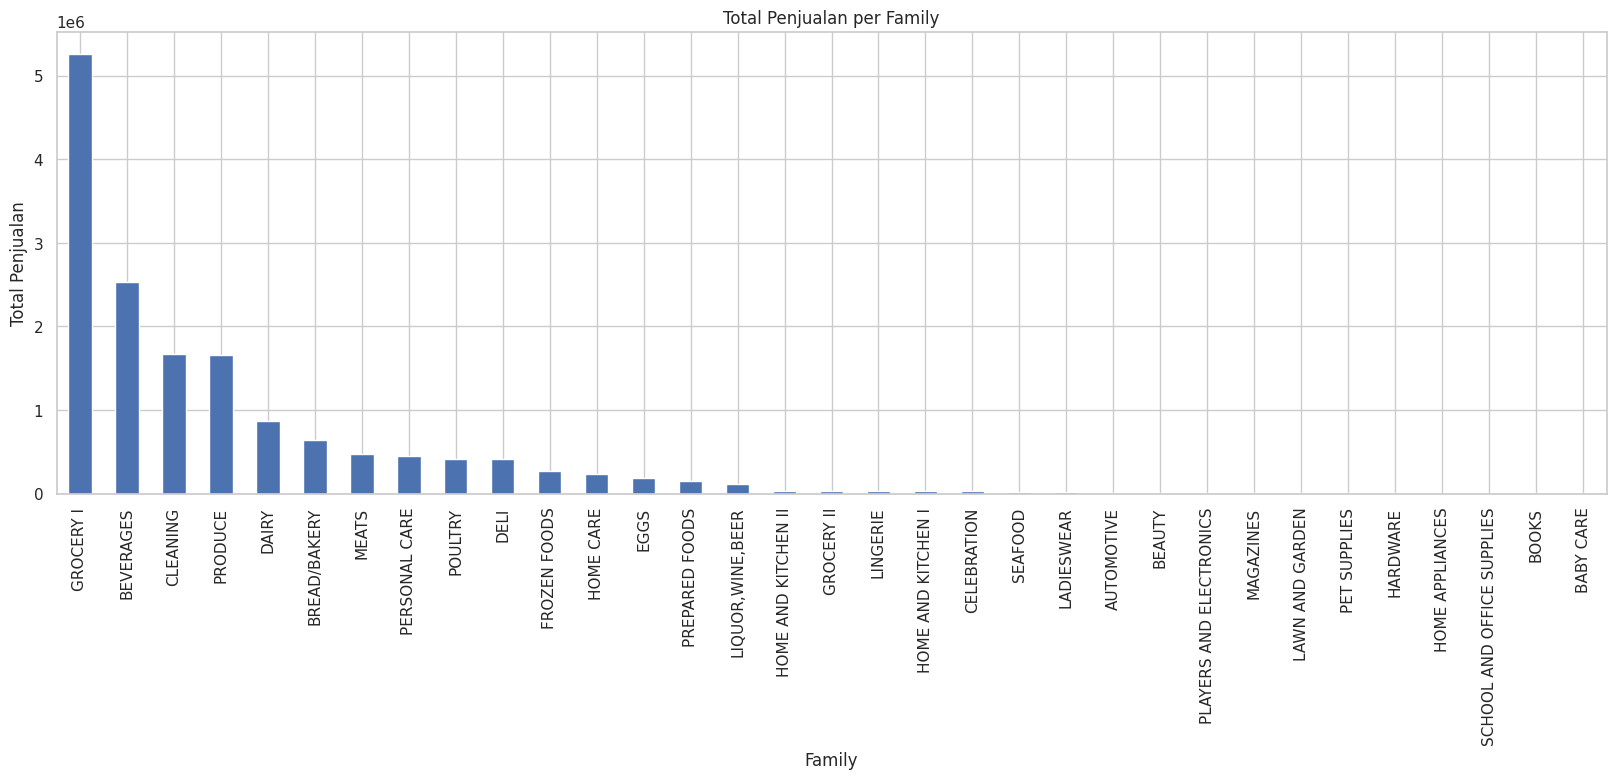

In [71]:
# plot data total penjualan berdasarkan family
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')

# Gunakan fungsi groupby dan sum untuk menghitung total penjualan per family
df_train.groupby('family')['sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Penjualan per Family')
plt.xlabel('Family')
plt.ylabel('Total Penjualan')
plt.show()

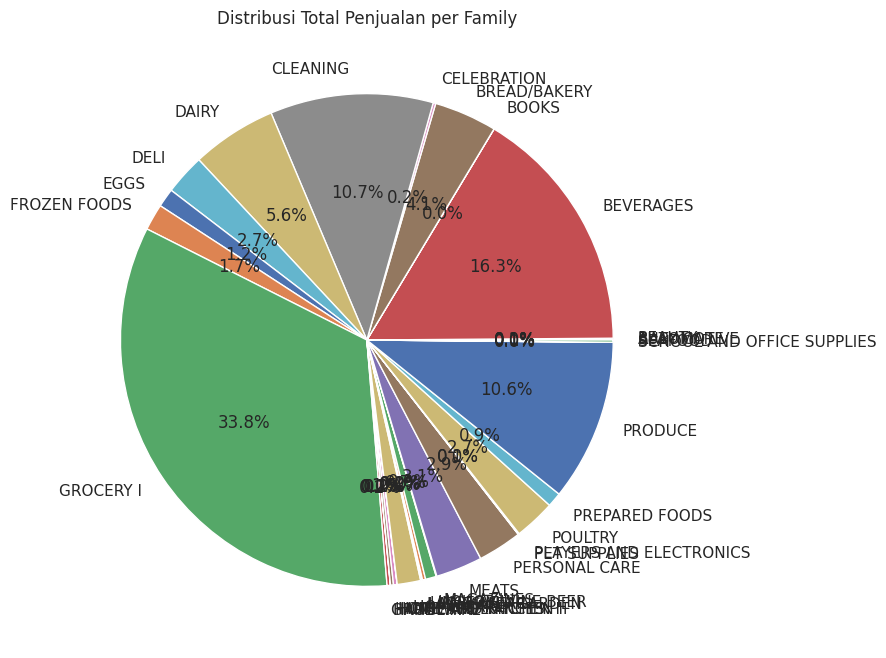

In [72]:
# Menghitung total penjualan per family
total_sales_per_family = df_train.groupby('family')['sales'].sum()

# Membuat pie chart
plt.figure(figsize=(10, 8))
total_sales_per_family.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribusi Total Penjualan per Family')
plt.ylabel('')  # Menghilangkan label y-axis karena tidak diperlukan di pie chart
plt.show()

(-1.1102934685239594,
 1.1104758852647363,
 -1.1103168777058816,
 1.110960173865113)

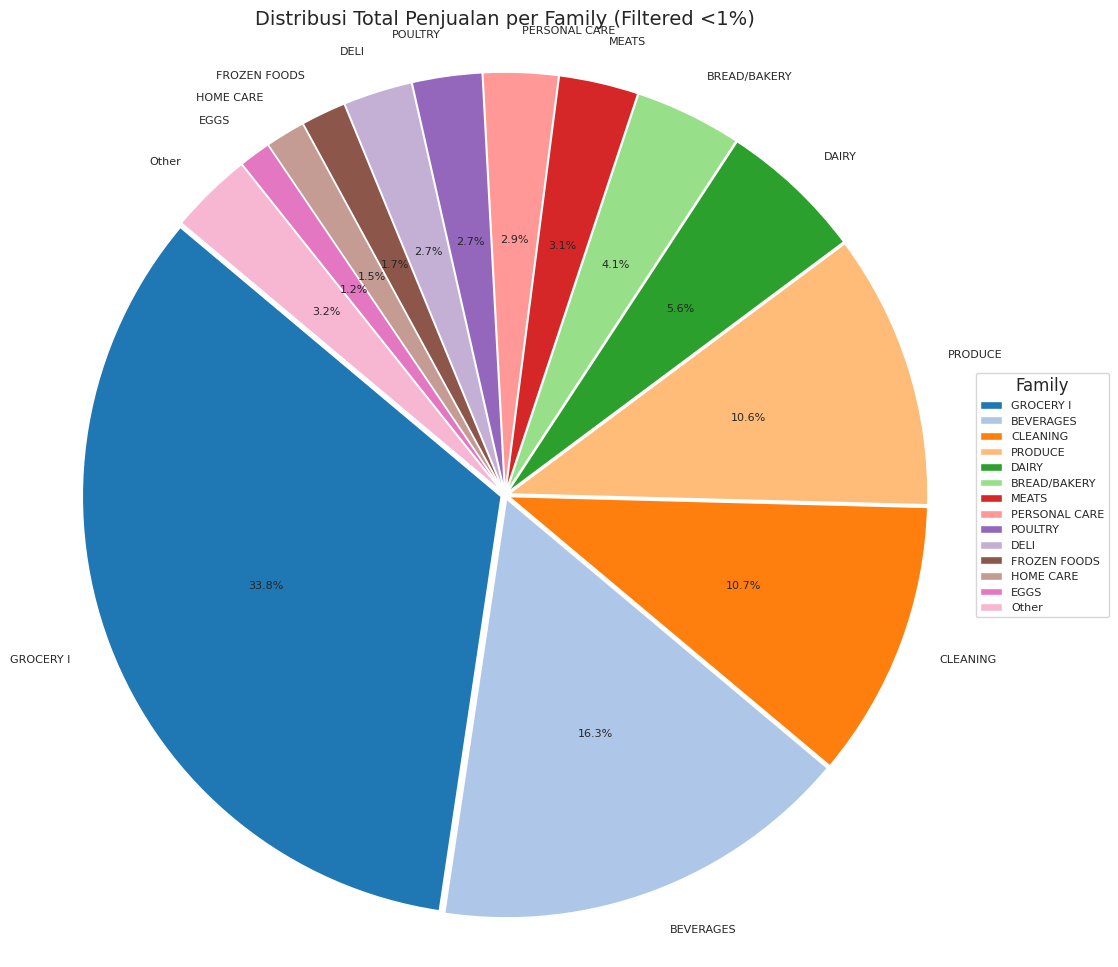

In [73]:
# Compute total sales per family and sort by quantity
total_sales_per_family = df_train.groupby('family')['sales'].sum().sort_values(ascending=False)

# Filter out small slices and aggregate them into 'Other'
threshold = 0.01  # 1%
small_slices = total_sales_per_family[total_sales_per_family / total_sales_per_family.sum() < threshold]
big_slices = total_sales_per_family[total_sales_per_family / total_sales_per_family.sum() >= threshold]
other_slice = small_slices.sum()
big_slices['Other'] = other_slice

# Explode the 'Other' slice if it's significant enough to be noticed, otherwise, don't explode any slices
explode = ([0.01] * len(big_slices))
if other_slice / total_sales_per_family.sum() < threshold:
    explode[-1] = 0  # Do not explode the 'Other' slice

colors = plt.cm.tab20.colors  # Use a predefined color map from matplotlib

plt.figure(figsize=(12, 12))  # Increase the figure size
plt.pie(
    big_slices,
    labels=big_slices.index,
    autopct=lambda p: '{:.1f}%'.format(p) if p >= 1 else '',  # Only show percentages >= 1%
    startangle=140,
    colors=colors,
    explode=explode,
    textprops={'fontsize': 8}
)

plt.title('Distribusi Total Penjualan per Family (Filtered <1%)', fontsize=14)
plt.legend(
    title='Family',
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=8
)
plt.axis('equal')


## EDA PERSONAL CARE

In [74]:
# Ambil data penjualan untuk family BOOKS
grocery = df_train['family']=='PERSONAL CARE'
grocery = df_train[grocery]
grocery

,family,sales
date,,
2013-01-01,PERSONAL CARE,0.0
2013-01-02,PERSONAL CARE,427.0
2013-01-03,PERSONAL CARE,312.0
2013-01-04,PERSONAL CARE,265.0
2013-01-05,PERSONAL CARE,330.0
...,...,...
2017-08-11,PERSONAL CARE,204.0
2017-08-12,PERSONAL CARE,159.0
2017-08-13,PERSONAL CARE,269.0


In [75]:
grocery

,family,sales
date,,
2013-01-01,PERSONAL CARE,0.0
2013-01-02,PERSONAL CARE,427.0
2013-01-03,PERSONAL CARE,312.0
2013-01-04,PERSONAL CARE,265.0
2013-01-05,PERSONAL CARE,330.0
...,...,...
2017-08-11,PERSONAL CARE,204.0
2017-08-12,PERSONAL CARE,159.0
2017-08-13,PERSONAL CARE,269.0


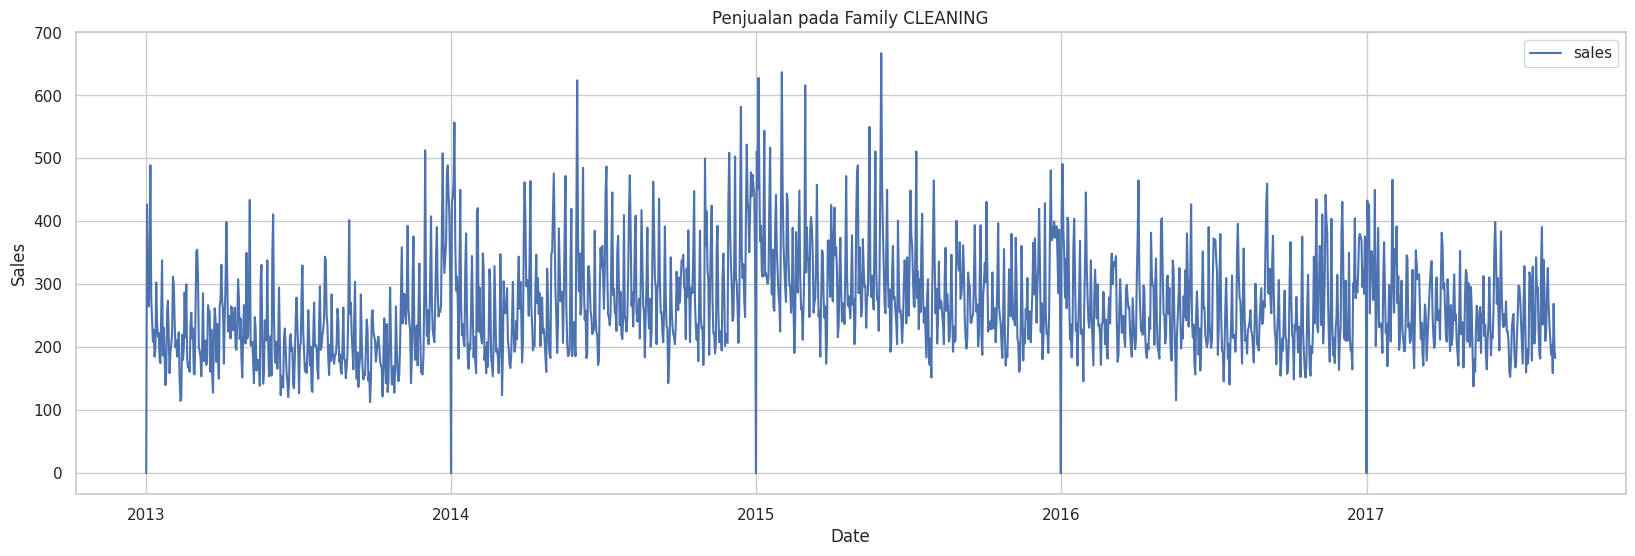

In [76]:
# Melihat penjualan pada family CLEANING
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sns.lineplot(data=grocery, x='date', y='sales', label='sales')
plt.title('Penjualan pada Family CLEANING')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

<Axes: xlabel='date'>

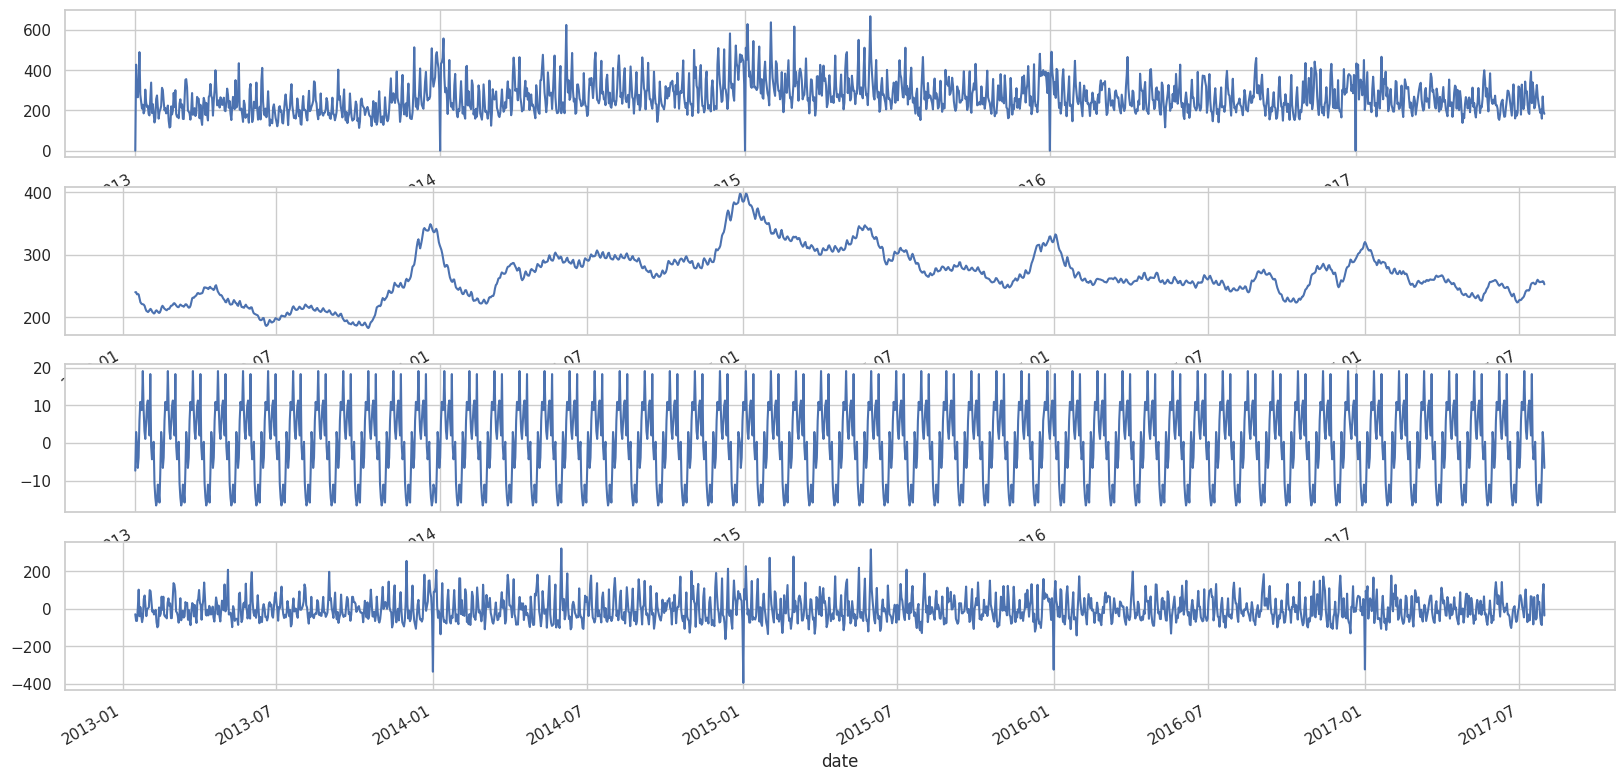

In [77]:
# Decompose data transactions
plot_decompose = seasonal_decompose(grocery['sales'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose.observed.plot(ax=ax1)
plot_decompose.trend.plot(ax=ax2)
plot_decompose.seasonal.plot(ax=ax3)
plot_decompose.resid.plot(ax=ax4)

In [78]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(grocery['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.236552
p-value: 0.000571


sudah cukup stasioner

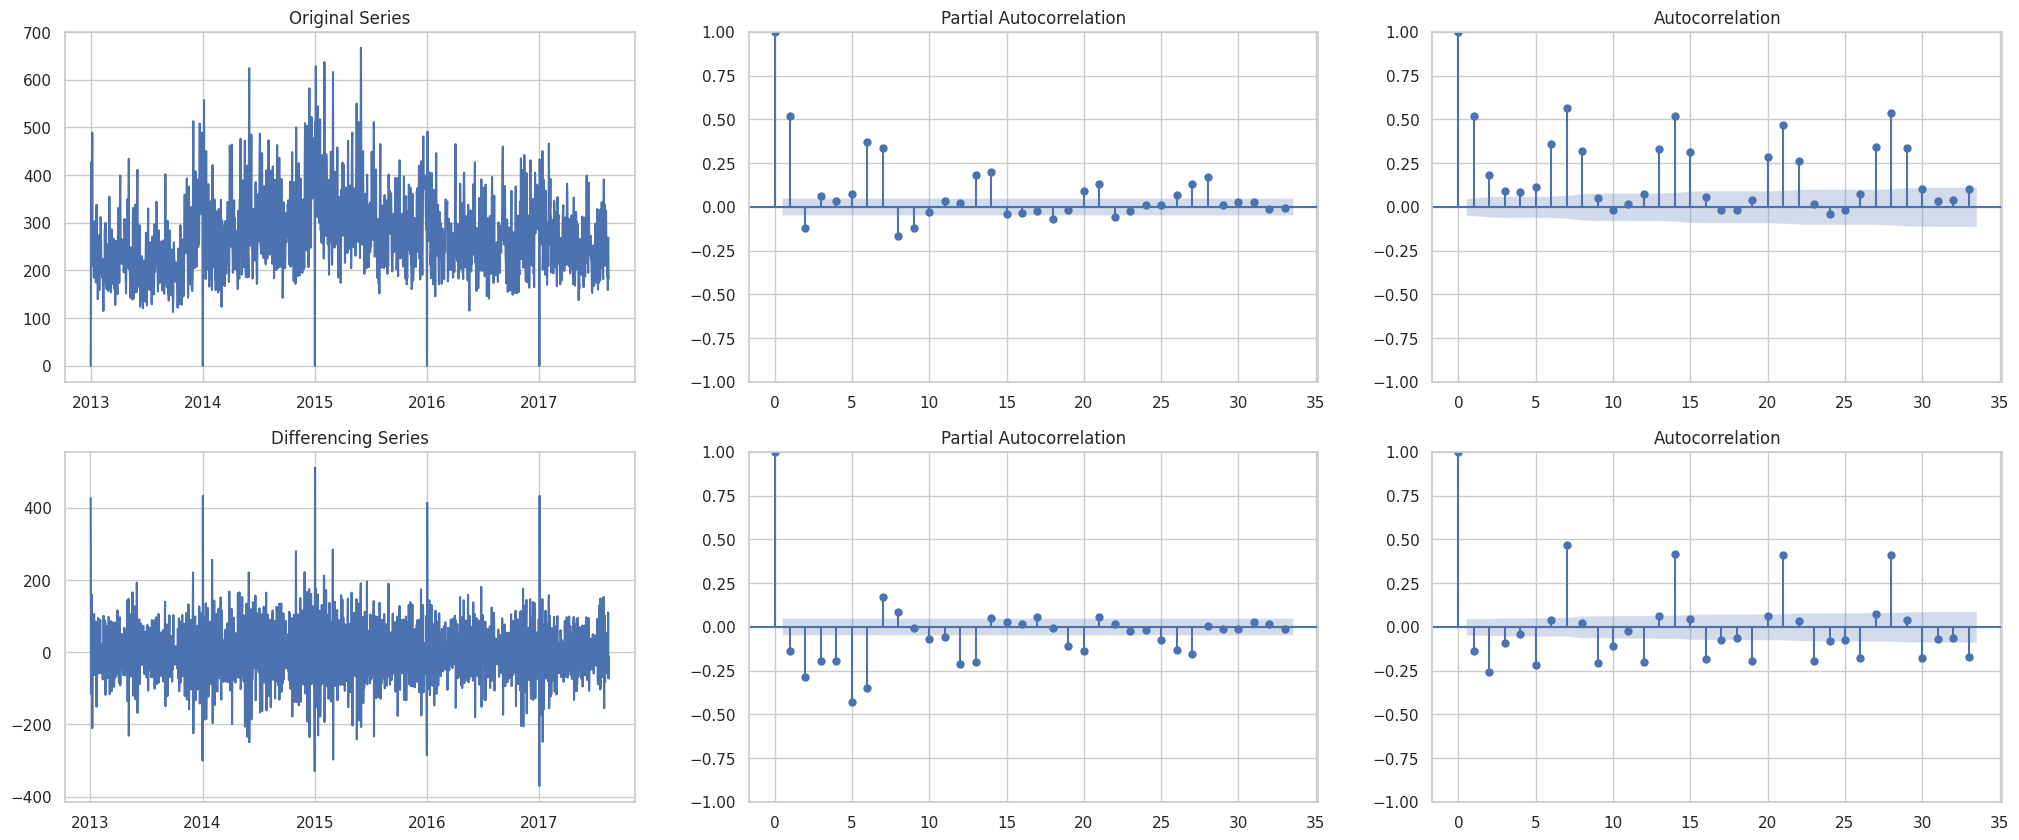

In [79]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(grocery['sales'])
ax[0, 1] = plot_pacf(grocery['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(grocery['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(grocery['sales'].diff().dropna())
ax[1, 1] = plot_pacf(grocery['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(grocery['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

# Feature Engineering


In [80]:
# Membagi fitur tanggal menjadi tahun, bulan, dan hari
grocery = grocery.copy()
grocery.loc[:, 'year'] = grocery.index.year
grocery.loc[:, 'month'] = grocery.index.month
grocery.loc[:, 'day'] = grocery.index.day
grocery.loc[:, 'dayofweek'] = grocery.index.dayofweek
grocery

,family,sales,year,month,day,dayofweek
date,,,,,,
2013-01-01,PERSONAL CARE,0.0,2013,1,1,1
2013-01-02,PERSONAL CARE,427.0,2013,1,2,2
2013-01-03,PERSONAL CARE,312.0,2013,1,3,3
2013-01-04,PERSONAL CARE,265.0,2013,1,4,4
2013-01-05,PERSONAL CARE,330.0,2013,1,5,5
...,...,...,...,...,...,...
2017-08-11,PERSONAL CARE,204.0,2017,8,11,4
2017-08-12,PERSONAL CARE,159.0,2017,8,12,5
2017-08-13,PERSONAL CARE,269.0,2017,8,13,6


In [81]:
# Menambahkan rolling window mean pada sales sepanjang 7 hari
grocery['sales_mean_7'] = grocery['sales'].rolling(window=7).mean()
# Menambahkan rolling window mean pada sales sepanjang 30 hari
grocery['sales_mean_30'] = grocery['sales'].rolling(window=30).mean()
grocery

,family,sales,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,
2013-01-01,PERSONAL CARE,0.0,2013,1,1,1,NaN,NaN
2013-01-02,PERSONAL CARE,427.0,2013,1,2,2,NaN,NaN
2013-01-03,PERSONAL CARE,312.0,2013,1,3,3,NaN,NaN
2013-01-04,PERSONAL CARE,265.0,2013,1,4,4,NaN,NaN
2013-01-05,PERSONAL CARE,330.0,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...
2017-08-11,PERSONAL CARE,204.0,2017,8,11,4,244.857143,257.066667
2017-08-12,PERSONAL CARE,159.0,2017,8,12,5,227.571429,256.566667
2017-08-13,PERSONAL CARE,269.0,2017,8,13,6,219.428571,259.233333


In [82]:
# Split data menjadi data training dan data testing
train = grocery[:-30]
test = grocery[-30:]
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1654, 8)
Test shape: (30, 8)


# Modeling

## Model ARIMA

In [83]:
#ARIMA
model_arima = ARIMA(train['sales'], order=(1, 0, 1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1654
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -9362.299
Date:                Fri, 15 Mar 2024   AIC                          18732.599
Time:                        13:57:10   BIC                          18754.243
Sample:                             0   HQIC                         18740.622
                               - 1654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        267.5966      3.596     74.407      0.000     260.548     274.645
ar.L1          0.3344      0.037      9.107      0.000       0.262       0.406
ma.L1          0.2660      0.038      7.057      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


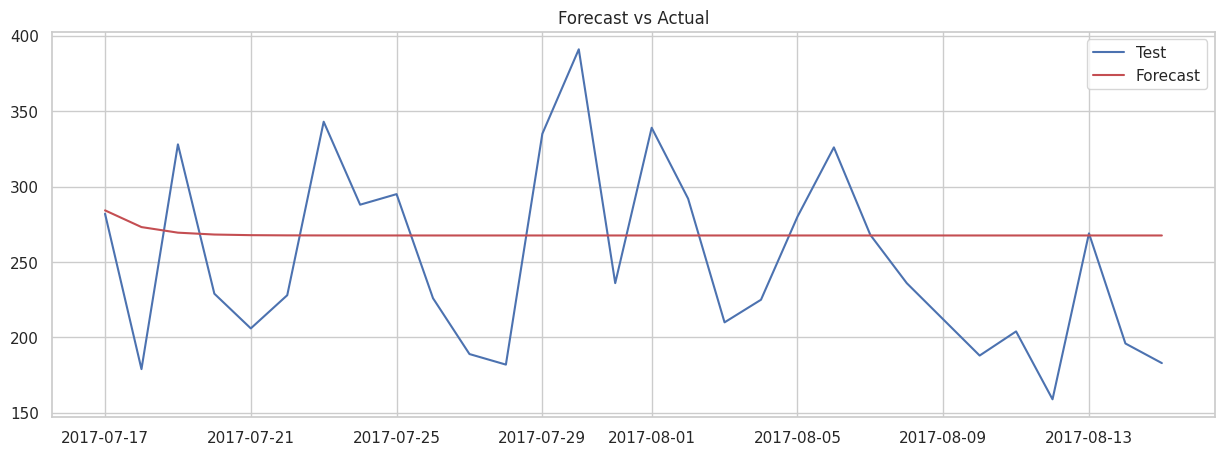

In [84]:
# Prediction
forecast = model_arima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [85]:
# check forecast row
forecastARIMA = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastARIMA

,test,forecast
date,,
2017-07-17,282.0,284.234387
2017-07-18,179.0,273.160795
2017-07-19,328.0,269.457440
2017-07-20,229.0,268.218923
2017-07-21,206.0,267.804724
2017-07-22,228.0,267.666203
2017-07-23,343.0,267.619877
2017-07-24,288.0,267.604384
2017-07-25,295.0,267.599203


## Model SARIMA


In [86]:
# Seasonal ARIMA (SARIMA)
model_sarima = ARIMA(train['sales'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1654
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -8978.635
Date:                         Fri, 15 Mar 2024   AIC                          17969.270
Time:                                 13:57:21   BIC                          18001.735
Sample:                                      0   HQIC                         17981.305
                                        - 1654                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        267.5904     14.630     18.291      0.000     238.917     296.264
ar.L1          0.6245      0.036     17.569      0.000     

order=(1, 0, 1) menunjukkan bahwa model menggunakan satu lag dari komponen AR (p=1), tidak ada diferensiasi (d=0, yang menunjukkan data sudah stasioner), dan satu lag dari komponen MA (q=1) untuk komponen non-musiman.

seasonal_order=(1, 0, 1, 7) menunjukkan bahwa model menggunakan satu lag dari komponen AR musiman (P=1), tidak ada diferensiasi musiman (D=0, yang menunjukkan data musiman sudah stasioner), satu lag dari komponen MA musiman (Q=1), dan data memiliki pola musiman yang berulang setiap tujuh periode (S=7, mungkin mengindikasikan data harian dengan pola mingguan).

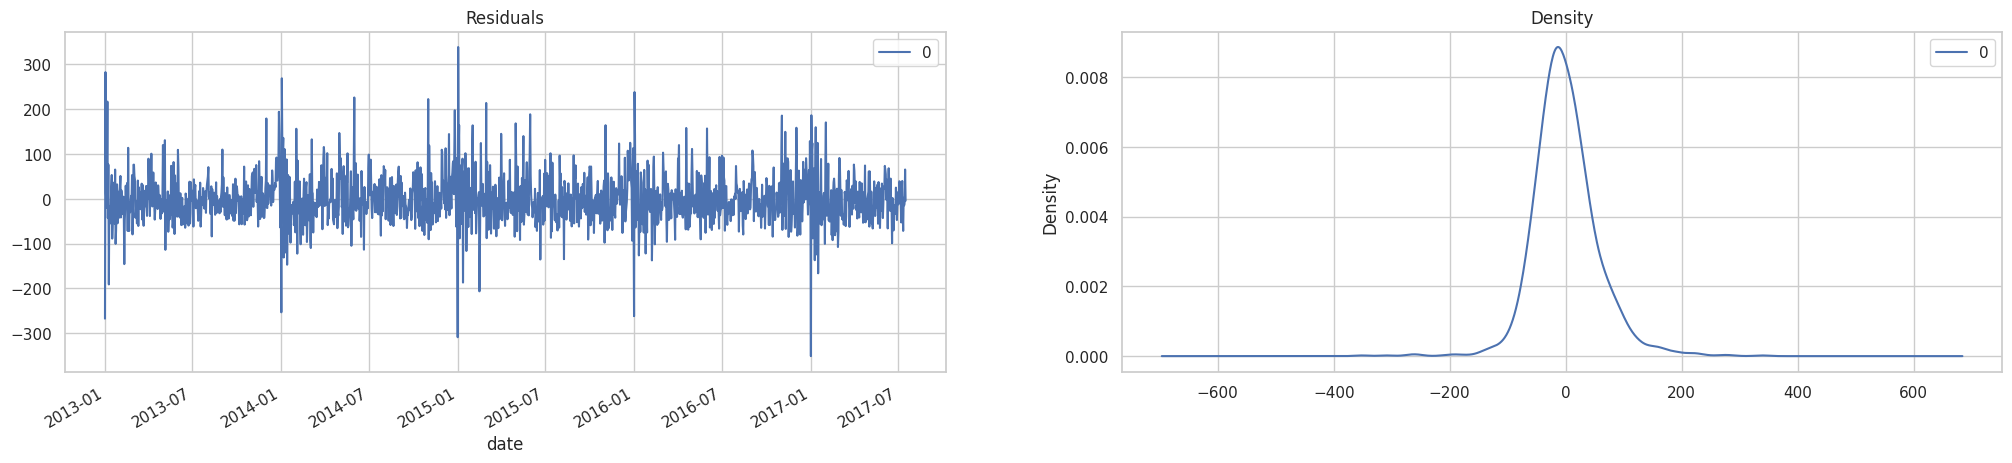

In [87]:
# Plot residual errors
residuals = pd.DataFrame(model_sarima_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


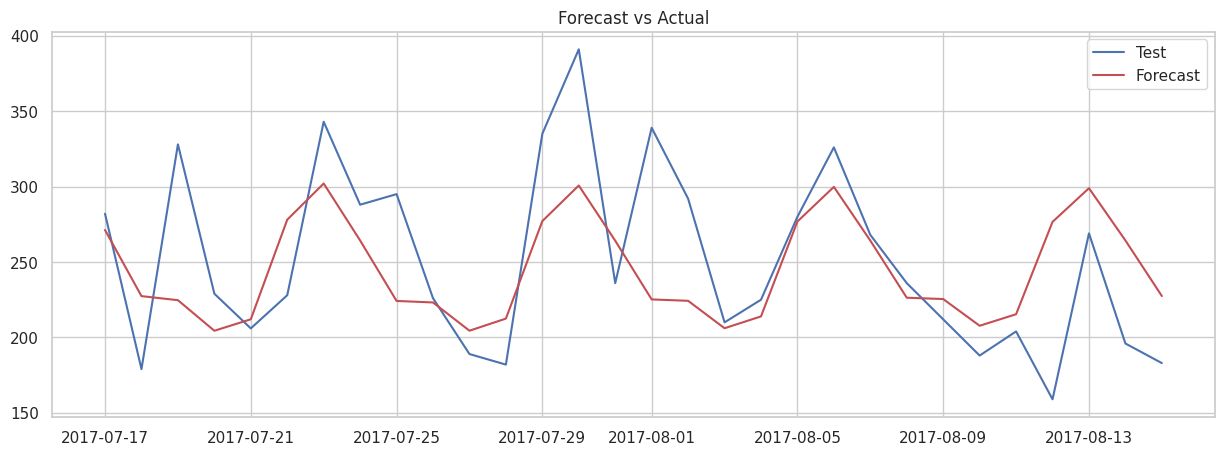

In [88]:
# Prediction
forecast = model_sarima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [89]:
# check forecast row
forecastSARIMA = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastSARIMA

,test,forecast
date,,
2017-07-17,282.0,271.208691
2017-07-18,179.0,227.386417
2017-07-19,328.0,224.705915
2017-07-20,229.0,204.440471
2017-07-21,206.0,212.045481
2017-07-22,228.0,278.068789
2017-07-23,343.0,302.045714
2017-07-24,288.0,264.281971
2017-07-25,295.0,224.202341


# Model LSTM

In [90]:
grocery

,family,sales,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,
2013-01-01,PERSONAL CARE,0.0,2013,1,1,1,NaN,NaN
2013-01-02,PERSONAL CARE,427.0,2013,1,2,2,NaN,NaN
2013-01-03,PERSONAL CARE,312.0,2013,1,3,3,NaN,NaN
2013-01-04,PERSONAL CARE,265.0,2013,1,4,4,NaN,NaN
2013-01-05,PERSONAL CARE,330.0,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...
2017-08-11,PERSONAL CARE,204.0,2017,8,11,4,244.857143,257.066667
2017-08-12,PERSONAL CARE,159.0,2017,8,12,5,227.571429,256.566667
2017-08-13,PERSONAL CARE,269.0,2017,8,13,6,219.428571,259.233333


In [91]:
# Forward fill for missing values
grocery.fillna(method='ffill', inplace=True)

In [92]:
# Normalize grocery
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(grocery[['sales']].values)

In [93]:
# Convert data to supervised learning problem
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [94]:
look_back = 1  # Number of previous time steps to consider
X, y = create_dataset(scaled_data, look_back)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [95]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [96]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
predictions = model.predict(X_test)

# Invert predictions
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

Epoch 1/100
43/43 [==============================] - 4s 5ms/step - loss: 0.1102
Epoch 2/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0145
Epoch 3/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 4/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 5/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 6/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 7/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 8/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0117
Epoch 9/100
43/43 [==============================] - 0s 9ms/step - loss: 0.0117
Epoch 10/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0115
Epoch 11/100
43/43 [==============================] - 0s 7ms/step - loss: 0.0116
Epoch 12/100
43/43 [==============================] - 0s 8ms/step - loss: 0.0116
Epoch 13/100
43/43 [=================

In [101]:
# Ensure both predictions and y_test are flattened (1D arrays) to avoid shape mismatch
predictions_flattened = predictions.flatten()
y_test_flattened = y_test.flatten()  # Assuming y_test was inversely transformed to a 2D array

In [102]:
from sklearn.metrics import r2_score

# Assume predictions and y_test are already defined as they were before

# Calculate Mean Squared Error (MSE)
mse = np.mean((predictions - y_test) ** 2)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(predictions - y_test))

# Calculate the R^2 score
r2 = r2_score(y_test_flattened, predictions_flattened)

# Print the errors
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")




Mean Squared Error (MSE): 5854.330794129978
Root Mean Squared Error (RMSE): 76.51359875296664
Mean Absolute Error (MAE): 60.88155575843378
R^2 Score: 0.12088885225475221


# Uji Metrik

In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [100]:
model = [forecastARIMA, forecastSARIMA]
model_name = ['ARIMA', 'SARIMA']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])

metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics

,MAE,MSE,R2
ARIMA,53.692945,3834.048312,-0.086248
SARIMA,38.259516,2584.543440,0.267757
